## Chapter 6 -  Decision Trees

### Visualising a Tree
To understand decision trees, we use the following tree trained using the iris dataset. 

<img src="tree1.png" width="300" />

It consists of a series of splitting rules starting from the top of the tree. To predict the class for a new iris sample, we start traversing from the top of the tree. In the top split, if the `petal length <= 2.45` it goes to the left branch. The prediction for this example is the `Setosa` class. If the `petal length > 2.45` then it goes to the right branch. Then we check if the `petal width <= 1.75`. If it is, go to the left branch where the predicted class is the `versicolor` class. Otherwise, to go the right branch where the predicted class is the `virginica` branch. Overall, the tree segments the iris flowers into 3 regions of prediction space. 

<b>Parts of a tree</b> - Some terms for the tree. The top node is the <u>root node</u>. In a traversal, we move from a <u>parent node</u> to a <u>child node</u>. The nodes with no more child nodes are <u>terminal nodes</u> or <u>leaf nodes</u> of the tree. The points along the tree are considered <u>internal nodes</u>. The segments of the tree that connects the nodes are <u>branches</u>.

<b>Feature Importance</b> - Observing the tree, we can say that `petal length` is the most important factor determining type of iris as it is present in the root node.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from graphviz import Source # For creating the visualisation of the decision tree

### Training a Tree
Given $n$ training examples, each with $p$ features $x_1, \cdots,x_i,\cdots, x_n \in \mathbb R^p$ and their associated class labels $y_1, \cdots, y_j, \cdots, y_n$ where each label is one of $K$ classes i.e. $y_i \in \{1,\cdots, K\}$. To train a decision tree, the following steps are taken in general:

1. Split the prediction space into $J$ distinct and non-overlapping regions, $R_1, \cdots, R_m, \cdots, R_J$. 
2. For a new observation that falls into $R_m \in \{1,\cdots, J\}$, the predicted class is the most commonly occuring class in the region (or the proportion of each class in the region).

For the Iris example, we have obtained 3 regions, from left $R_1, R_2, R_3$. The response in each of the nodes is $R_1=\text{setosa}$, $R_2=\text{versicolor}$, $R_3=\text{virginica}$ respectively. So for a new observation $x^*$, if $x^* \in R_1$ then its class prediction is `Setosa`.

To construct the regions $R_m$, we find regions that maximise class purity. Two ways to measure class purity are Gini impurity or Entropy. 

Given a region $R_m$ with $n_{R_m}$observations from each class $k \in \{1,\cdots,K\}$, Gini impurity / Gini Index is calculated as:
$$G_{R_m,\text{Gini}} = 1-\sum_{k=1}^{K}p_{R_m,k}^2$$
where $p_{R_m,k}$ is the ratio of class $k$ instances among all the training instances in the region $R_m$. It can be also shown that the expression is the same as $\sum_{k=1}^{K}p_{R_m,k}(1 - p_{R_m,k})$. 

<b>Interpretation</b> - If the node consists of observations from predominantly one class, all the $p_{R_m,k}$ are close to zero or one. Consequently, the Gini index takes on a small value. That means a small Gini index indicates that a node consists predominantly observations from a single class, or high class purity.

<b>Numerical Example</b>

Consider the tree built for the iris dataset. For a pure node with $50$ observations consisting of a class split of $[50,0,0]$ the Gini score is $1-\begin{pmatrix}\frac{0}{50}\end{pmatrix}^2-\begin{pmatrix}\frac{0}{50}\end{pmatrix}^2-\begin{pmatrix}\frac{50}{50}\end{pmatrix}^2= 0.0$ 

For a node with $54$ observations with a class split of $[0,49,5]$ the Gini score is $1-\begin{pmatrix}\frac{0}
{54}\end{pmatrix}^2-\begin{pmatrix}\frac{49}{54}\end{pmatrix}^2-\begin{pmatrix}\frac{5}{54}\end{pmatrix}^2= 0.168$ 



In [2]:
# Gini Calculations
print(1-(0/50)**2-(0/50)**2-(50/50)**2)
print(1-(0/54)**2-(49/54)**2-(5/54)**2)
print(1-(0/100)**2-(50/100)**2-(50/100)**2)

0.0
0.1680384087791495
0.5


Alternatively, Entropy or cross-entropy is calculated as:
$$G_{R_m,\text{Entropy}} = -\sum_{k=1, p_{R_m,k}\neq 0}^K p_{R_m,k}\log p_{R_m,k}$$
Note: The bottom term of the summation $p_{R_m,k}\neq 0$ means to omit all classes $k$ in the node $R_m$ with no observations. This is to remove all terms that result in the expression $\log 0$. 

<b>Interpretation</b> - The cross entropy is near zero if all the $p_{R_m,k}$ are close to zero or one - hence, similar to the Gini index, the cross entropy score will take a small value if the node is pure.

<b>Numerical Example</b>

For a pure node with $50$ observations consisting of a class split of $[50,0,0]$, the Entropy calculation is $-\frac{50}{50} \log\begin{pmatrix}\frac{50}{50}\end{pmatrix}^2= 0$ 

For a node with $54$ observations with a class split of $[0,49,5]$, the Gini score is $-\begin{pmatrix}\frac{49}{54}\end{pmatrix}\log\begin{pmatrix}\frac{49}{54}\end{pmatrix}-\begin{pmatrix}\frac{5}{54}\end{pmatrix}\log\begin{pmatrix}\frac{5}{54}\end{pmatrix}= 0.308$ 


In [3]:
#Entropy Calculations
print(-(50/50)*np.log(50/50))
print(-(49/54)*np.log(49/54)-(5/54)*np.log(5/54))
print(-(50/100)*np.log(50/100))

-0.0
0.30849545083110386
0.34657359027997264


SKLearn uses the Classification and Regression Tree (CART) algorithm to train Decision Trees. To perform the split, the model first splits the training set using a feature $g$ from $p$ and a threshold within this feature $t_g$. For this feature-threshold pair $(g,t_g)$, calculate the purity of the subsets produced using its cost function:

$$J(g,t_g) = \frac{m_{\text{left}}}{m}G_\text{left} + \frac{m_{\text{right}}}{m}G_\text{right}$$

where $G_{\text{left or right}}$ is the impurity of the left or right subset and $m_{\text{left or right}}$ is the number of instances in the left or right subset. $m$ is the number of observations before the split. The cost function now has the term $G$ that uses the Gini index or Entropy index. The split with the pureset subsets also results in the smallest values of $G$, and collectively minimises the cost function $J$.

Once it has successfully split the training set in two, it continues to do so recursively until it reaches the max depth or it cannot find a split to further reduce impurity.

In [4]:
# Ingest
iris_dataset = datasets.load_iris()
X = pd.DataFrame(iris_dataset['data'], columns=iris_dataset['feature_names'])
y = pd.Series(iris_dataset['target'])
df = X.copy().join(pd.DataFrame({'target' : y}))

In [5]:
# For testing
# display(df.head())
# display(X.head())
# display(y.head())

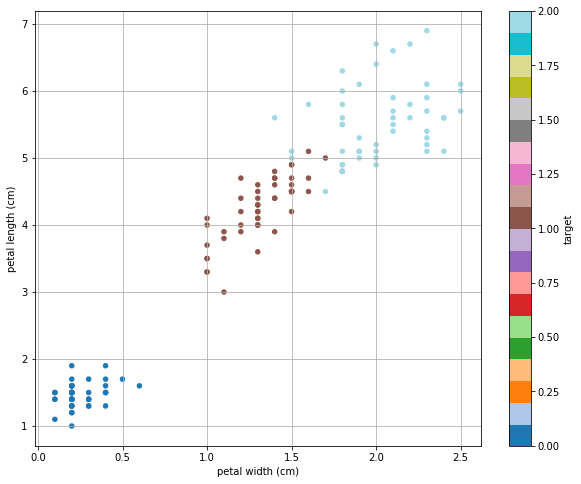

In [6]:
# Plot petal width, petal length and class values
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
df.plot(kind='scatter', x='petal width (cm)', y='petal length (cm)', c='target', colormap='tab20', ax=ax)
ax.grid()
plt.show()

In [7]:
# Train
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X[['petal length (cm)','petal width (cm)']], y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [8]:
# Visualise tree
# graph = Source(export_graphviz(tree_clf, out_file=None, 
#                                feature_names=iris_dataset['feature_names'][2:], class_names=iris_dataset['target_names']))
# graph.view()

### Discussions

To determine whether to use Gini or Entropy, most of the time it does not matter but Gini tends to isolate the most frequent class in its own branch of the tree while entropy leads to more balanced trees.

Decision trees can be constructed even if the predictor variables are qualitative. In such a split, one branch usually has one value and the other branch contains the remaining values for this variable.

Note that decision trees can split and yield two nodes that have the same predicted value. However, this split is still performed to preserve node purity. In other words, the parent node might have 75% from one class, but the prediction class is still not pure. These splits improve the Gini index or cross-entropy, which are more sensitive to node purity.

Decision trees have orgotonal decision boundaries (splits are perpendicular to an axis), which makes the training set sensitive to rotation. One way to help with this is to use PCA. Decision trees are also sensitive to small variations in the data. Random forests can be a way to limit these sensitivities.

Decision trees can be useful if the response cannot be approximated by a linear model, or there is no linear relationship between the features and the response. Also, 

- trees are easier to explain / interpret for the layman
- they can easily handle qualitative predictors without the need to create dummy variables
- decision trees are said to closely mirror human decision making, more appropriate than regression approaches
- however, they are prone to overfit and might not have the same predictive strength as compared to other approaches

### Making Predictions

In [9]:
new_s = [[5,1.5]]
print('prediction : ', tree_clf.predict(new_s))

prediction :  [1]


### Estimating Class Probabilities

A decision tree can also estimate the probability that the instance belongs to a particular class $k$. First it traverses the tree to find the leaf node. Then it returns the ratio of training instances of class $k$ for this node. 

In this case, the number of class 1 for this leaf node is 49 out of 54 so the predicted probability is $\frac{49}{54}=0.907$

In [10]:
new_s = [[5,1.5]]
print('proba : ' , tree_clf.predict_proba(new_s))

proba :  [[0.         0.90740741 0.09259259]]
